In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gym_guppy.envs import VariableStepGuppyEnv
from gym_guppy.guppies import ToTargetRobot

from gym_guppy.tools.math import sigmoid
from gym_guppy.tools.controller import ForwardController, OrientationController

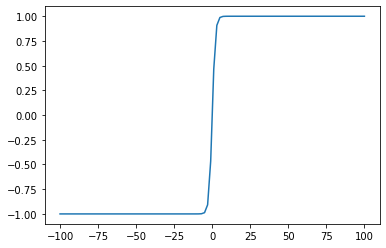

In [2]:
slope_dist = 1.
error = np.linspace(-100., 100., 100)

s = sigmoid(error, slope_dist)
plt.plot(error, s)

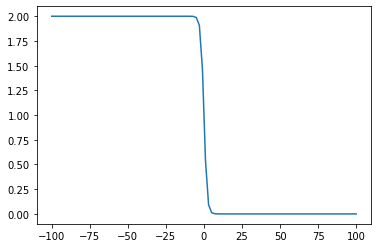

In [3]:
s = sigmoid(error, slope_dist)
plt.plot(error, 1.-s)

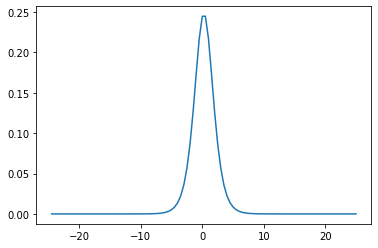

In [4]:
error = np.linspace(-25., 25., 101)
s1 = sigmoid(error[1:], slope_dist)
s2 = sigmoid(error[:-1], slope_dist)
plt.plot(error[1:], s1-s2)

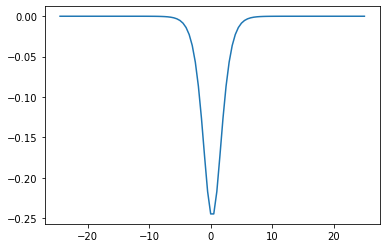

In [5]:
plt.plot(error[1:], (1.-s1)-(1.-s2))

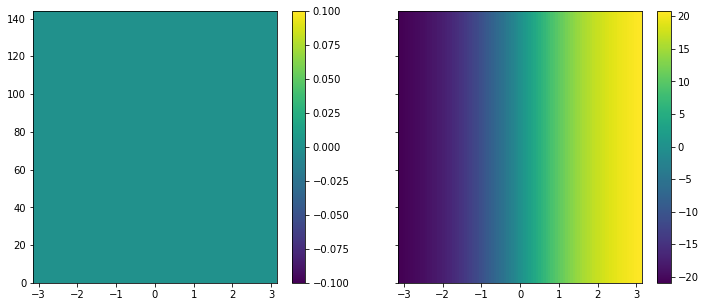

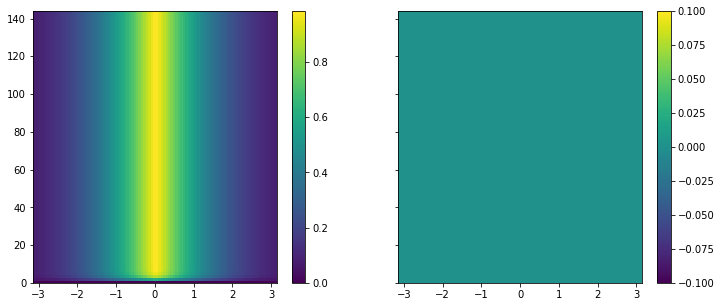

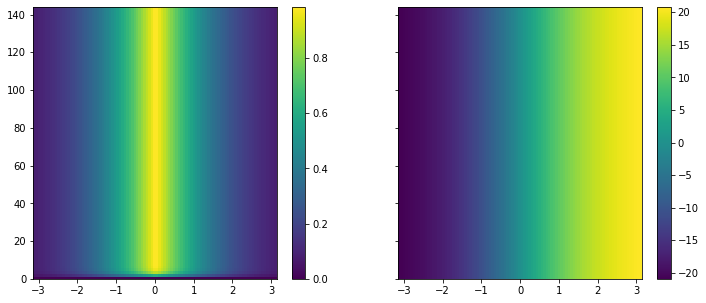

In [6]:
ori_error = np.linspace(-np.pi, np.pi, 100)
pos_error = np.linspace(.0, 144., 100)
ori_e, pos_e = np.meshgrid(ori_error, pos_error)

ori_controller = OrientationController()
ori_motor_speeds = ori_controller.speeds(ori_e, pos_e)

x_vel, r_vel = ori_motor_speeds.get_local_velocities()

f, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
pcm0 = ax0.pcolormesh(ori_e, pos_e, x_vel)
plt.colorbar(pcm0, ax=ax0)
pcm1 = ax1.pcolormesh(ori_e, pos_e, r_vel)
plt.colorbar(pcm1, ax=ax1)

fwd_controller = ForwardController()
fwd_motor_speeds = fwd_controller.speeds(ori_e, pos_e)

x_vel, r_vel = fwd_motor_speeds.get_local_velocities()

f, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
pcm0 = ax0.pcolormesh(ori_e, pos_e, x_vel)
plt.colorbar(pcm0, ax=ax0)
pcm1 = ax1.pcolormesh(ori_e, pos_e, r_vel)
plt.colorbar(pcm1, ax=ax1)

x_vel, r_vel = (fwd_motor_speeds + ori_motor_speeds).get_local_velocities()

f, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
pcm0 = ax0.pcolormesh(ori_e, pos_e, x_vel)
plt.colorbar(pcm0, ax=ax0)
pcm1 = ax1.pcolormesh(ori_e, pos_e, r_vel)
plt.colorbar(pcm1, ax=ax1)

In [7]:
controller_params = {
    'ori_ctrl_params': {
        'p': 1.,
        'speed': .01
    },
    'fwd_ctrl_params': {
        'p': 1.,
        'speed': .01,
        'p_dist_error_factor': 100.
    }
}

class TestEnv(VariableStepGuppyEnv):
    world_size = world_width, world_height = 1., 1.
    def _reset(self):
        self._add_robot(ToTargetRobot(world=self.world,
                                      world_bounds=self.world_bounds,
                                      position=np.array([-0.01584549,  0.02128319]),
                                      orientation=2.4684281,
                                      ctrl_params=controller_params))

env = TestEnv()
# env.render('human')

next target: [0. 0.]
next target: [-0.3  0.3]
next target: [0.3 0.3]
next target: [ 0.3 -0.3]
next target: [-0.3 -0.3]
next target: [-0.3  0.3]
next target: [ 0.3 -0.3]
next target: [0. 0.]


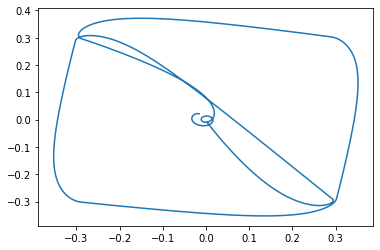

In [8]:
env.reset()
# env.render('human')
action_list = np.array([[.0, .0],
                        [-.3, .3],
                        [.3, .3],
                        [.3, -.3],
                        [-.3, -.3],
                        [-.3, .3],
                        [.3, -.3],
                        [.0, .0]])

# action_list = np.array([[.0, .0],
#                         [-.1, .0]])

steps = []

for a in action_list:
    print(f'next target: {a}')
    # local_action = env.robot.get_local_point(a)
    observation, reward, done, info = env.step(a)
    steps.append(info['steps'])
    
steps_array = np.concatenate(steps)
plt.plot(steps_array[:, 0], steps_array[:, 1])

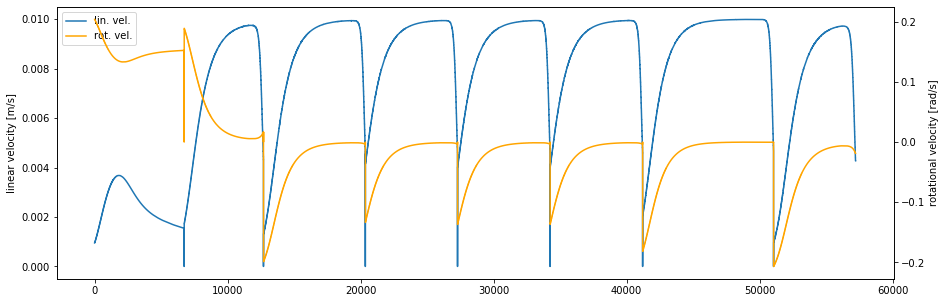

In [9]:
lin_vel = np.sqrt(np.sum(np.diff(steps_array[:, :2], axis=0)**2, axis=1)) * 100.
rot_vel = np.diff(steps_array[:, 2]) * 100.

f, ax1 = plt.subplots(figsize=(15,5))

l1, = ax1.plot(lin_vel)
l1.set_label('lin. vel.')
ax1.set_ylabel('linear velocity [m/s]')

ax2 = ax1.twinx()

l2, = ax2.plot(rot_vel, c='orange')
l2.set_label('rot. vel.')
ax2.set_ylabel('rotational velocity [rad/s]')

ax1.legend((l1, l2), ('lin. vel.', 'rot. vel.'))


In [27]:
robot_tj = np.load("/Users/gregor/Downloads/2020-01-22_totarget/2020-01-22-16-56_robot.npy")
targets = np.load("/Users/gregor/Downloads/2020-01-22_totarget/2020-01-22-16-56_targets.npy")

import pandas as pd
robot_df = pd.DataFrame(robot_tj, columns=['x', 'y', 'cos', 'sin'])
robot_df['asin'] = np.arcsin(robot_df['sin'])
robot_df['acos'] = np.arccos(robot_df['cos'])
d_asin = np.diff(robot_df['asin'])
d_acos = np.diff(robot_df['acos'])
dtheta = np.where(np.abs(d_asin) < np.abs(d_acos), d_asin, d_acos)

# from scipy import stats
# robot_df = robot_df[(np.abs(stats.zscore(robot_df)) < 2).all(axis=1)]

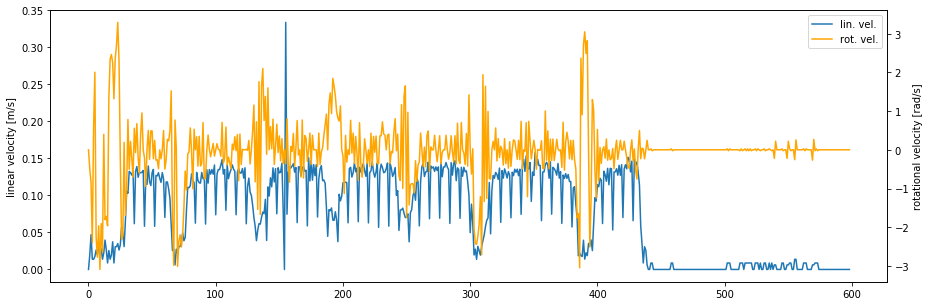

In [28]:
lin_vel = np.sqrt(np.sum(np.diff(robot_df[['x', 'y']], axis=0)**2, axis=1)) * 10.
# rot_vel = np.diff(robot_df['theta']) * 10.
rot_vel = dtheta * 10.

f, ax1 = plt.subplots(figsize=(15,5))

l1, = ax1.plot(lin_vel)
l1.set_label('lin. vel.')
ax1.set_ylabel('linear velocity [m/s]')

ax2 = ax1.twinx()

l2, = ax2.plot(rot_vel, c='orange')
l2.set_label('rot. vel.')
ax2.set_ylabel('rotational velocity [rad/s]')

ax1.legend((l1, l2), ('lin. vel.', 'rot. vel.'))

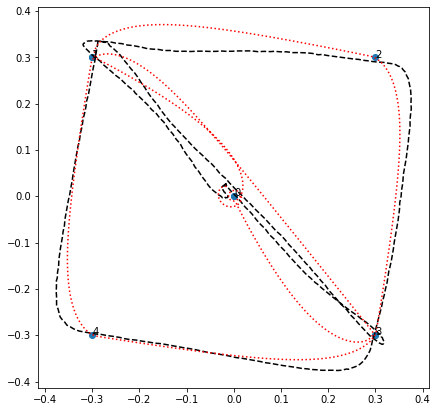

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(targets[:,0]/100 - .5, -targets[:,1]/100 + .5)
for i in range(5):
    ax.annotate(str(i), (targets[i, 0] / 100 - .5, -targets[i, 1] / 100 + .5))

ax.plot(robot_tj[:,0], robot_tj[:,1], '--k')

ax.plot(steps_array[:, 0], steps_array[:, 1], ':r')

In [14]:
robot_tj[0]

array([-0.01584549,  0.02128319, -0.78185266,  0.6234633 ], dtype=float32)

In [41]:
np.arctan2(robot_tj[0, 3], robot_tj[0, 2])



2.4684281